In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
COLOURS = {
    0: "#CCCCCC",
    1: "#0000FF",
    2: "#007F00",
    3: "#BE0000",
    4: "#000080",
    5: "#800000",
    6: "#4D829E",
    7: "#000000",
    8: "#808080",
    -1: "#FF8000", # mines
}

# Play the game

In [11]:
class BinomialGrid:
    def __init__(self, num_rows, num_cols, mine_frac, binomial=True, same_sample=False, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        self.binomial = binomial
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.num_mines = int(mine_frac * num_rows * num_cols)
        self.mine_grid = torch.zeros((num_rows, num_cols)).bool()
        self.flags = torch.zeros((num_rows, num_cols)).bool()
        self.visibles = torch.zeros((num_rows, num_cols)).bool()
        self.won = False
        self.lost = False
        mine_indices = torch.randperm(num_rows * num_cols)[:self.num_mines]
        for index in mine_indices:
            self.mine_grid[index // num_cols, index % num_cols] = True

        padded_mine_grid = torch.nn.functional.pad(self.mine_grid, (1, 1, 1, 1)) # To generate adjacencies
        adjacents = [
            # Orthogonally adjacent
            torch.roll(padded_mine_grid, shifts=(1,), dims=(0,)),
            torch.roll(padded_mine_grid, shifts=(-1,), dims=(0,)),
            torch.roll(padded_mine_grid, shifts=(1,), dims=(1,)),
            torch.roll(padded_mine_grid, shifts=(-1,), dims=(1,)),
            # Diagonally adjacent
            torch.roll(padded_mine_grid, shifts=(1,1), dims=(0,1)),
            torch.roll(padded_mine_grid, shifts=(1,-1), dims=(0,1)),
            torch.roll(padded_mine_grid, shifts=(-1,1), dims=(0,1)),
            torch.roll(padded_mine_grid, shifts=(-1,-1), dims=(0,1))
        ]
        if binomial:
            if same_sample:
                sample_adj = sum([adjacents[i] for i in torch.randint(8, (8,))])[1:-1, 1:-1]
            else:
                sample_adj = torch.gather(
                    torch.stack(adjacents, dim=-1), 
                    dim=2, 
                    index=torch.randint(8, (num_rows + 2, num_cols + 2, 8))
                ).sum(dim=2)[1:-1, 1:-1]
            self.combined = (sample_adj - 100 * self.mine_grid).clip(min=-1) # i.e., mines are -1
        else:
            self.combined = (sum(adjacents)[1:-1, 1:-1] - 100 * self.mine_grid).clip(min=-1)
            
    def visualise(self, fig, ax):
        data = self.combined.cpu().numpy()
        rows, cols = data.shape
        # fig, ax = plt.subplots(figsize=(cols * 0.5, rows * 0.5))
        ax.imshow(1 - self.visibles.int(), cmap="grey", origin="upper", vmin=-10, vmax=1)
        for i in range(rows):
            for j in range(cols):
                value = data[i, j]
                if not self.visibles[i, j]:
                    continue # i.e., don't show the non-guessed ones
                # Place the text in the center of the cell
                text = "⚑" if self.flags[i, j] else ("●" if data[i, j] == -1 else str(int(data[i, j])))
                colour = "#8000FF" if self.flags[i, j] else COLOURS[value]
                ax.text(
                    j, i, text, 
                    ha="center", va="center", 
                    color=colour, fontsize=20, fontname="monospace", fontweight="bold"
                )

        # Text if they won or not
        if self.won or self.lost:
            colour = "green" if self.won else "red"
            text = "YOU WIN" if self.won else "YOU LOSE"
            ax.text(
                (num_cols - 1) / 2, (num_rows - 1) / 2, text,
                ha="center", va="center", 
                color=colour, fontsize=50, fontname="monospace", fontweight="bold"
            )
        # ax.set_axis_off()
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor("black")
            spine.set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([])

    def get_representation(self):
        """
        Returns tensor, which is numbers as you would expect
        But with -1 for all the non-visible ones
        (this is for the model, won't be used normally)
        """
        return (self.combined + 100 * (self.visibles.int() - 1)).clip(min=-1)

    def guess(self, row, col):
        """
        Guess (row, col) in the grid
        Returns True if it's not a mine, False if it is
        """
        self.visibles[row, col] = True
        if self.mine_grid[row, col]: # i.e., hit a mine
            self.lost = True
            self.visibles.fill_(True)
            return False
        if (not self.binomial) and (self.combined[row, col] == 0): # i.e., no adjacent mines
            # Note this gets skipped if the game is binomial - 0 can be next to mines!
            for row_incr in [-1, 0, 1]:
                for col_incr in [-1, 0, 1]:
                    new_row = row + row_incr
                    new_col = col + col_incr
                    if (
                        (new_row < 0 or new_row >= self.num_rows) # check row in bounds
                        or (new_col < 0 or new_col >= self.num_cols) # check col in bounds
                        or self.visibles[new_row, new_col]
                    ):
                        continue
                    self.guess(new_row, new_col)
        return True

    def flag(self, row, col):
        """
        Add a flag! Simple as
        Also if you flag something that's already a flag, it flips, i.e., unflag naturally
        """
        if ~self.flags[row, col]:
            self.flags[row, col] = True
            self.visibles[row, col] = True
        else:
            self.flags[row, col] = False
            self.visibles[row, col] = False # If unflag, it's now unknown
        if ( # See if you win with this flag
            (self.combined[self.flags] == -1).all() # all flags cover mines
            & (self.flags.sum() == self.num_mines) # no excess flags
        ):
            print("You win!!")
            self.won = True
            self.visibles.fill_(True)
            return True

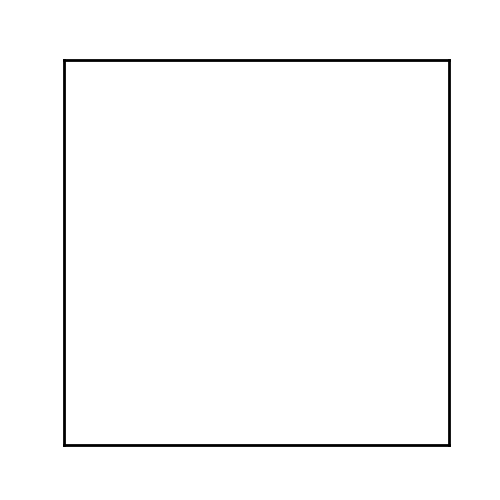

In [30]:
num_rows = 10
num_cols = 10
mine_frac = 0.1
grid = BinomialGrid(num_rows, num_cols, mine_frac, binomial=True, same_sample=True, seed=8)

def on_click(event):
    print(event)
    ax.cla()
    if event.xdata is None: 
        return
    col, row = int(event.xdata + 0.5), int(event.ydata + 0.5)
    if event.button == 1:  # left click
        grid.guess(row, col)
    elif event.button == 3:  # right click
        win = grid.flag(row, col)

    grid.visualise(fig, ax)

fig, ax = plt.subplots(figsize=(num_cols / 2, num_rows / 2))
fig.canvas.mpl_connect("button_press_event", on_click)
grid.visualise(fig, ax)